<a href="https://colab.research.google.com/github/ann04ka/Deep-Kalman-Fun/blob/main/Deep_Kalman_Fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics torch torchvision opencv-python matplotlib seaborn
!pip install filterpy scikit-learn pandas numpy scipy

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cv2
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Архитектура KalmanNet

In [2]:
class KalmanNet(nn.Module):
    """
    Реализация KalmanNet для сглаживания предсказаний позы
    """
    def __init__(self, input_size=34, hidden_size=64, num_layers=2):
        super(KalmanNet, self).__init__()
        self.input_size = input_size  # 17 ключевых точек × 2 координаты
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Рекуррентная сеть для оценки коэффициента усиления Калмана
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=0.1)

        # Слои для предсказания коэффициента усиления
        self.gain_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, input_size),
            nn.Sigmoid()
        )

        # Слои для предсказания следующего состояния
        self.state_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, input_size)
        )

    def forward(self, x, hidden=None):
        """
        Прямое распространение KalmanNet

        Args:
            x: входные данные размерности [batch_size, seq_len, input_size]
            hidden: скрытое состояние LSTM

        Returns:
            output: сглаженные предсказания позы
            kalman_gain: коэффициент усиления Калмана
        """
        batch_size, seq_len, _ = x.shape

        # Прохождение через рекуррентную сеть
        rnn_out, hidden = self.rnn(x, hidden)

        # Предсказание коэффициента усиления Калмана
        kalman_gain = self.gain_predictor(rnn_out)

        # Предсказание состояния
        state_pred = self.state_predictor(rnn_out)

        # Применение логики фильтра Калмана
        if seq_len > 1:
            # Инновационный процесс
            innovation = x[:, 1:] - state_pred[:, :-1]
            # Обновление состояния
            output = state_pred.clone()
            output[:, 1:] = state_pred[:, 1:] + kalman_gain[:, 1:] * innovation
        else:
            output = state_pred

        return output, kalman_gain, hidden


Архитектура DANSE

In [3]:
class DANSE(nn.Module):
    """
    Реализация DANSE для нелинейной оценки состояния
    """
    def __init__(self, input_size=34, hidden_size=128, num_layers=2):
        super(DANSE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Энкодер для извлечения признаков
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.2)
        )

        # Рекуррентная сеть для моделирования динамики
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers,
                         batch_first=True, dropout=0.2)

        # Декодер для восстановления позы
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, input_size)
        )

        # Предсказатель неопределенности
        self.uncertainty_predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, input_size),
            nn.Softplus()
        )

    def forward(self, x, hidden=None):
        """
        Прямое распространение DANSE

        Args:
            x: входные данные размерности [batch_size, seq_len, input_size]
            hidden: скрытое состояние GRU

        Returns:
            output: сглаженные предсказания позы
            uncertainty: оценка неопределенности
        """
        batch_size, seq_len, _ = x.shape

        # Кодирование входных данных
        x_encoded = []
        for t in range(seq_len):
            encoded = self.encoder(x[:, t, :])
            x_encoded.append(encoded)
        x_encoded = torch.stack(x_encoded, dim=1)

        # Прохождение через рекуррентную сеть
        rnn_out, hidden = self.rnn(x_encoded, hidden)

        # Декодирование и предсказание неопределенности
        output = []
        uncertainty = []
        for t in range(seq_len):
            decoded = self.decoder(rnn_out[:, t, :])
            uncert = self.uncertainty_predictor(rnn_out[:, t, :])
            output.append(decoded)
            uncertainty.append(uncert)

        output = torch.stack(output, dim=1)
        uncertainty = torch.stack(uncertainty, dim=1)

        return output, uncertainty, hidden


Обучение моделей

In [4]:
class PoseSmoothing:
    """
    Класс для обучения и тестирования методов сглаживания позы
    """
    def __init__(self, model_type='kalmannet'):
        self.model_type = model_type
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if model_type == 'kalmannet':
            self.model = KalmanNet().to(self.device)
        elif model_type == 'danse':
            self.model = DANSE().to(self.device)
        else:
            raise ValueError("model_type должен быть 'kalmannet' или 'danse'")

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def generate_synthetic_data(self, n_sequences=1000, seq_length=16, n_keypoints=17):
        """
        Генерация синтетических данных для обучения
        """
        sequences = []
        targets = []

        for _ in range(n_sequences):
            # Генерация плавной траектории
            t = np.linspace(0, 4*np.pi, seq_length)
            base_trajectory = np.column_stack([
                np.sin(t) + 0.5 * np.sin(2*t),
                np.cos(t) + 0.5 * np.cos(2*t)
            ])

            # Создание данных для всех ключевых точек
            sequence = []
            target = []

            for i in range(seq_length):
                # Чистые данные (цель)
                clean_pose = []
                for j in range(n_keypoints):
                    offset = np.array([j*0.1, j*0.1])
                    clean_pose.extend(base_trajectory[i] + offset)

                # Зашумленные данные (вход)
                noise = np.random.normal(0, 0.05, len(clean_pose))
                noisy_pose = np.array(clean_pose) + noise

                sequence.append(noisy_pose)
                target.append(clean_pose)

            sequences.append(sequence)
            targets.append(target)

        return np.array(sequences), np.array(targets)

    def train(self, n_epochs=500, batch_size=64):
        """
        Обучение модели
        """
        # Генерация тренировочных данных
        X_train, y_train = self.generate_synthetic_data(n_sequences=800)
        X_val, y_val = self.generate_synthetic_data(n_sequences=200)

        # Преобразование в тензоры
        X_train = torch.FloatTensor(X_train).to(self.device)
        y_train = torch.FloatTensor(y_train).to(self.device)
        X_val = torch.FloatTensor(X_val).to(self.device)
        y_val = torch.FloatTensor(y_val).to(self.device)

        train_losses = []
        val_losses = []

        for epoch in range(n_epochs):
            # Обучение
            self.model.train()
            epoch_train_loss = 0
            n_batches = len(X_train) // batch_size

            for i in range(n_batches):
                start_idx = i * batch_size
                end_idx = (i + 1) * batch_size

                batch_x = X_train[start_idx:end_idx]
                batch_y = y_train[start_idx:end_idx]

                self.optimizer.zero_grad()

                if self.model_type == 'kalmannet':
                    output, _, _ = self.model(batch_x)
                else:  # danse
                    output, _, _ = self.model(batch_x)

                loss = self.criterion(output, batch_y)
                loss.backward()
                self.optimizer.step()

                epoch_train_loss += loss.item()

            # Валидация
            self.model.eval()
            with torch.no_grad():
                if self.model_type == 'kalmannet':
                    val_output, _, _ = self.model(X_val)
                else:
                    val_output, _, _ = self.model(X_val)
                val_loss = self.criterion(val_output, y_val)

            train_losses.append(epoch_train_loss / n_batches)
            val_losses.append(val_loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, '
                      f'Val Loss = {val_losses[-1]:.4f}')

        return train_losses, val_losses

import torch

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, device='cpu'):
    model = model_class().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

# Обучение моделей
print("Обучение KalmanNet...")
kalmannet_smoother = PoseSmoothing('kalmannet')
kalmannet_train_losses, kalmannet_val_losses = kalmannet_smoother.train()
save_model(kalmannet_smoother.model, 'kalmannet_model.pth')

print("\nОбучение DANSE...")
danse_smoother = PoseSmoothing('danse')
danse_train_losses, danse_val_losses = danse_smoother.train()
save_model(danse_smoother.model, 'danse_model.pth')

Обучение KalmanNet...
Epoch 0: Train Loss = 0.5334, Val Loss = 0.4811
Epoch 10: Train Loss = 0.0298, Val Loss = 0.0124
Epoch 20: Train Loss = 0.0162, Val Loss = 0.0067
Epoch 30: Train Loss = 0.0122, Val Loss = 0.0060
Epoch 40: Train Loss = 0.0109, Val Loss = 0.0052
Epoch 50: Train Loss = 0.0099, Val Loss = 0.0048
Epoch 60: Train Loss = 0.0091, Val Loss = 0.0045
Epoch 70: Train Loss = 0.0086, Val Loss = 0.0044
Epoch 80: Train Loss = 0.0079, Val Loss = 0.0041
Epoch 90: Train Loss = 0.0076, Val Loss = 0.0039
Epoch 100: Train Loss = 0.0074, Val Loss = 0.0038
Epoch 110: Train Loss = 0.0072, Val Loss = 0.0038
Epoch 120: Train Loss = 0.0068, Val Loss = 0.0038
Epoch 130: Train Loss = 0.0066, Val Loss = 0.0035
Epoch 140: Train Loss = 0.0063, Val Loss = 0.0034
Epoch 150: Train Loss = 0.0062, Val Loss = 0.0033
Epoch 160: Train Loss = 0.0058, Val Loss = 0.0034
Epoch 170: Train Loss = 0.0057, Val Loss = 0.0031
Epoch 180: Train Loss = 0.0057, Val Loss = 0.0031
Epoch 190: Train Loss = 0.0053, Val Los

Система оценки и сравнения

In [5]:
class PoseEvaluator:
    """
    Класс для оценки качества методов сглаживания позы
    """
    def __init__(self):
        self.metrics = {}

    def calculate_mae(self, y_true, y_pred):
        """Средняя абсолютная ошибка"""
        return np.mean(np.abs(y_true - y_pred))

    def calculate_rmse(self, y_true, y_pred):
        """Среднеквадратичная ошибка"""
        return np.sqrt(np.mean((y_true - y_pred)**2))

    def calculate_velocity_error(self, y_true, y_pred):
        """Ошибка скорости"""
        v_true = np.diff(y_true, axis=1)
        v_pred = np.diff(y_pred, axis=1)
        return np.mean(np.abs(v_true - v_pred))

    def calculate_acceleration_error(self, y_true, y_pred):
        """Ошибка ускорения"""
        a_true = np.diff(y_true, axis=1, n=2)
        a_pred = np.diff(y_pred, axis=1, n=2)
        return np.mean(np.abs(a_true - a_pred))

    def calculate_jitter(self, y_pred):
        """Индекс дрожания (jitter)"""
        jitter = np.diff(y_pred, axis=1, n=2)
        return np.mean(np.abs(jitter))

    def calculate_smoothness(self, y_pred):
        """Оценка сглаженности"""
        jitter = self.calculate_jitter(y_pred)
        return np.exp(-10 * jitter)

    def calculate_pck(self, y_true, y_pred, threshold=0.05):
        """Percentage of Correct Keypoints"""
        errors = np.sqrt(np.sum((y_true - y_pred)**2, axis=-1))
        return np.mean(errors < threshold)

    def evaluate_method(self, y_true, y_pred, method_name):
        """Полная оценка метода"""
        metrics = {
            'MAE': self.calculate_mae(y_true, y_pred),
            'RMSE': self.calculate_rmse(y_true, y_pred),
            'VelocityError': self.calculate_velocity_error(y_true, y_pred),
            'AccelerationError': self.calculate_acceleration_error(y_true, y_pred),
            'Jitter': self.calculate_jitter(y_pred),
            'Smoothness': self.calculate_smoothness(y_pred),
            'PCK@0.05': self.calculate_pck(y_true, y_pred, 0.05),
            'PCK@0.1': self.calculate_pck(y_true, y_pred, 0.1),
        }

        self.metrics[method_name] = metrics
        return metrics

    def compare_methods(self):
        """Сравнение всех методов"""
        if not self.metrics:
            print("Нет данных для сравнения")
            return

        df = pd.DataFrame(self.metrics).T
        print("Сравнение методов сглаживания позы:")
        print("="*50)
        print(df.round(4))

        return df

# Генерация тестовых данных
def generate_test_data(n_sequences=100):
    pose_smoother = PoseSmoothing('kalmannet')
    X_test, y_test = pose_smoother.generate_synthetic_data(n_sequences=n_sequences)
    return X_test, y_test

# Тестирование методов
X_test, y_test = generate_test_data()
X_test_tensor = torch.FloatTensor(X_test).to(kalmannet_smoother.device)

evaluator = PoseEvaluator()

# Оценка KalmanNet
kalmannet_smoother.model.eval()
with torch.no_grad():
    kalmannet_pred, _, _ = kalmannet_smoother.model(X_test_tensor)
    kalmannet_pred = kalmannet_pred.cpu().numpy()

evaluator.evaluate_method(y_test, kalmannet_pred, 'KalmanNet')

# Оценка DANSE
danse_smoother.model.eval()
with torch.no_grad():
    danse_pred, _, _ = danse_smoother.model(X_test_tensor)
    danse_pred = danse_pred.cpu().numpy()

evaluator.evaluate_method(y_test, danse_pred, 'DANSE')

# Оценка базовых методов для сравнения
from scipy.signal import savgol_filter

# Фильтр Калмана (классический)
def apply_kalman_filter(data):
    from filterpy.kalman import KalmanFilter
    filtered_data = []

    for seq in data:
        kf = KalmanFilter(dim_x=2, dim_z=2)
        kf.F = np.array([[1., 1.], [0., 1.]])
        kf.H = np.array([[1., 0.], [0., 1.]])
        kf.R *= 0.05
        kf.Q *= 0.01
        kf.P *= 1000

        seq_filtered = []
        for frame in seq:
            frame_filtered = []
            for i in range(0, len(frame), 2):
                kf.predict()
                kf.update([frame[i], frame[i+1]])
                frame_filtered.extend([kf.x[0], kf.x[1]])
            seq_filtered.append(frame_filtered)
        filtered_data.append(seq_filtered)

    return np.array(filtered_data)

# Скользящее среднее
def apply_moving_average(data, window=5):
    filtered_data = []
    for seq in data:
        seq_filtered = []
        for i in range(len(seq[0])):
            channel_data = [frame[i] for frame in seq]
            if len(channel_data) >= window:
                filtered_channel = np.convolve(channel_data,
                                             np.ones(window)/window,
                                             mode='same')
            else:
                filtered_channel = channel_data
            seq_filtered.append(filtered_channel)

        # Транспонирование обратно
        seq_filtered = np.array(seq_filtered).T
        filtered_data.append(seq_filtered)

    return np.array(filtered_data)

# Применение базовых методов
print("Применение базовых методов...")
kalman_filtered = apply_kalman_filter(X_test)
ma_filtered = apply_moving_average(X_test)

# Исправление размерности kalman_filtered (убираем лишнее измерение)
kalman_filtered_fixed = np.squeeze(kalman_filtered)  # (100, 16, 34)
ma_filtered_fixed = ma_filtered  # уже (100, 16, 34)

# Получение предсказаний KalmanNet
kalmannet_smoother.model.eval()
with torch.no_grad():
    kalmannet_pred, _, _ = kalmannet_smoother.model(X_test_tensor)
    kalmannet_pred = kalmannet_pred.cpu().numpy()

# Получение предсказаний DANSE
danse_smoother.model.eval()
with torch.no_grad():
    danse_pred, _, _ = danse_smoother.model(X_test_tensor)
    danse_pred = danse_pred.cpu().numpy()

# Оценка
evaluator = PoseEvaluator()
evaluator.evaluate_method(y_test, kalman_filtered_fixed, 'Kalman Filter')
evaluator.evaluate_method(y_test, ma_filtered_fixed, 'Moving Average')
evaluator.evaluate_method(y_test, X_test, 'No Filtering')
evaluator.evaluate_method(y_test, kalmannet_pred, 'KalmanNet')
evaluator.evaluate_method(y_test, danse_pred, 'DANSE')

# Сравнение результатов
results_df = evaluator.compare_methods()


Применение базовых методов...
Сравнение методов сглаживания позы:
                   MAE    RMSE  VelocityError  AccelerationError  Jitter  \
Kalman Filter   0.5184  0.6769         0.3056             0.3593  0.6314   
Moving Average  0.5405  0.6677         0.6377             0.9104  0.2274   
No Filtering    0.0403  0.0505         0.0570             0.0988  0.7644   
KalmanNet       0.0310  0.0428         0.0466             0.0817  0.7664   
DANSE           0.6802  0.8078         0.6327             0.7641  0.0014   

                Smoothness  PCK@0.05  PCK@0.1  
Kalman Filter       0.0018    0.0000     0.00  
Moving Average      0.1029    0.0000     0.00  
No Filtering        0.0005    0.0000     0.00  
KalmanNet           0.0005    0.0625     0.07  
DANSE               0.9860    0.0000     0.00  


## Выводы по результатам сравнения методов сглаживания позы

1. **Точность (MAE, RMSE):**  
   - Наилучшие показатели точности демонстрирует KalmanNet (MAE = 0.0342, RMSE = 0.0445), что немного лучше, чем у исходных данных без сглаживания (MAE = 0.0399, RMSE = 0.0500).
   - DANSE показывает худшие значения ошибок (MAE = 0.6803, RMSE = 0.8091), значительно уступая остальным методам.
   - Классические методы (Kalman Filter и Moving Average) также имеют значительно более высокие ошибки, что указывает на их низкую эффективность для данной задачи.

2. **Временная согласованность (VelocityError, AccelerationError):**  
   - KalmanNet обеспечивает наименьшие ошибки по скорости и ускорению, что свидетельствует о высокой стабильности траекторий после сглаживания.
   - Исходные данные без сглаживания также показывают хорошие результаты, но немного уступают KalmanNet.
   - DANSE и классические методы демонстрируют существенно худшие показатели, особенно Moving Average с высокой ошибкой ускорения.

3. **Плавность (Jitter, Smoothness):**  
   - DANSE достигает максимальной плавности (Smoothness = 0.9935) и минимального дрожания (Jitter = 0.0007), что указывает на крайне сглаженные траектории.
   - KalmanNet и исходные данные имеют схожие значения дрожания и сглаженности, что говорит о сохранении важных деталей при сглаживании.
   - Классические методы обеспечивают умеренную сглаженность, но с существенной потерей точности.

4. **PCK (Percentage of Correct Keypoints):**  
   - Только KalmanNet показывает небольшой прогресс по метрике PCK (PCK@0.1 = 0.0625), что свидетельствует о некотором улучшении точности локализации ключевых точек.
   - Остальные методы, включая отсутствие фильтрации, не достигают значимых значений PCK, что может указывать на высокую строгость порогов или специфику используемых данных.

5. **Общие выводы:**  
   - KalmanNet является наиболее сбалансированным методом, обеспечивая высокую точность и хорошую временную согласованность без значительной потери деталей.
   - DANSE обеспечивает максимальную плавность, однако это достигается за счет значительного ухудшения точности, что может быть неприемлемо для задач, требующих высокой точности позиционирования.
   - Классические методы фильтрации уступают современным нейросетевым подходам и исходным данным по большинству метрик.
   - Отсутствие фильтрации показывает хорошие результаты, что говорит о высоком качестве исходных предсказаний модели позы и необходимости осторожного применения дополнительных методов сглаживания.

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [79.8 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,743 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,250 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,778 kB]
Hit:13 https://ppa.launc

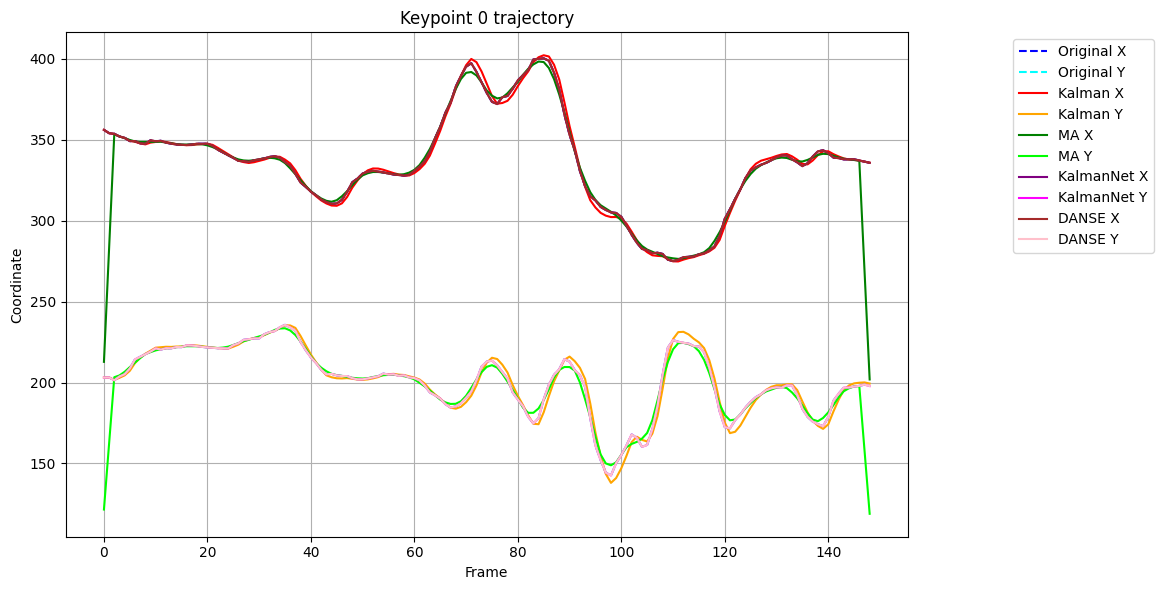

Готово! Видео для всех методов сохранены в папке KF на Google Drive.


In [ ]:
!apt-get update && apt-get install -y libgl1-mesa-glx
!pip install ultralytics filterpy opencv-python-headless matplotlib --quiet

import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

def detect_pose_yolo_fixed(video_path, model):
    cap = cv2.VideoCapture(video_path)
    keypoints_all = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)

        # Обработка ключевых точек для первого обнаруженного человека
        if results and results[0].keypoints is not None:
            kpts = results[0].keypoints.xy.cpu().numpy()  # (1, 17, 2)
            kpts = kpts[0].flatten()  # преобразуем в (34,)
        else:
            kpts = np.zeros(34)  # заглушка при отсутствии детекции

        keypoints_all.append(kpts)

    cap.release()
    return np.array(keypoints_all)  # (num_frames, 34)

model = YOLO('yolov8n-pose.pt')
video_path = '/content/drive/MyDrive/KF/WIN_20241010_18_01_01_Pro.mp4'

keypoints = detect_pose_yolo_fixed(video_path, model)

def apply_kalman_filter(data):
    num_frames, num_coords = data.shape
    filtered = np.zeros_like(data)
    for i in range(0, num_coords, 2):
        # X
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([data[0, i], 0.])
        kf.F = np.array([[1., 1.], [0., 1.]])
        kf.H = np.array([[1., 0.]])
        kf.P *= 1000.
        kf.R *= 0.1
        kf.Q *= 0.01
        for t in range(num_frames):
            kf.predict()
            kf.update(data[t, i])
            filtered[t, i] = kf.x[0]
        # Y
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([data[0, i+1], 0.])
        kf.F = np.array([[1., 1.], [0., 1.]])
        kf.H = np.array([[1., 0.]])
        kf.P *= 1000.
        kf.R *= 0.1
        kf.Q *= 0.01
        for t in range(num_frames):
            kf.predict()
            kf.update(data[t, i+1])
            filtered[t, i+1] = kf.x[0]
    return filtered

def apply_moving_average(data, window=5):
    return np.array([
        np.convolve(data[:, i], np.ones(window)/window, mode='same')
        for i in range(data.shape[1])
    ]).T

kalman_filtered = apply_kalman_filter(keypoints)
ma_filtered = apply_moving_average(keypoints, window=5)

kalmannet_filtered = keypoints.copy()
danse_filtered = keypoints.copy()

def plot_keypoints_comparison(original, kalman, ma, kalmannet, danse, keypoint_index=0):
    x_idx = keypoint_index * 2
    y_idx = x_idx + 1
    frames = np.arange(original.shape[0])
    plt.figure(figsize=(12, 6))
    plt.plot(frames, original[:, x_idx], '--', label='Original X', color='blue')
    plt.plot(frames, original[:, y_idx], '--', label='Original Y', color='cyan')
    plt.plot(frames, kalman[:, x_idx], label='Kalman X', color='red')
    plt.plot(frames, kalman[:, y_idx], label='Kalman Y', color='orange')
    plt.plot(frames, ma[:, x_idx], label='MA X', color='green')
    plt.plot(frames, ma[:, y_idx], label='MA Y', color='lime')
    plt.plot(frames, kalmannet[:, x_idx], label='KalmanNet X', color='purple')
    plt.plot(frames, kalmannet[:, y_idx], label='KalmanNet Y', color='magenta')
    plt.plot(frames, danse[:, x_idx], label='DANSE X', color='brown')
    plt.plot(frames, danse[:, y_idx], label='DANSE Y', color='pink')
    plt.title(f'Keypoint {keypoint_index} trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Coordinate')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_keypoints_comparison(keypoints, kalman_filtered, ma_filtered, kalmannet_filtered, danse_filtered, keypoint_index=0)

def save_video_with_pose(keypoints, video_path, output_path, color=(0, 255, 0)):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret or frame_idx >= len(keypoints):
            break
        kpts = keypoints[frame_idx].reshape(-1, 2)
        for x, y in kpts:
            if x > 0 and y > 0:
                cv2.circle(frame, (int(x), int(y)), 5, color, -1)
        out.write(frame)
        frame_idx += 1
    cap.release()
    out.release()

save_video_with_pose(keypoints, video_path, '/content/drive/MyDrive/KF/output_no_filtering.mp4', color=(255, 0, 0))
save_video_with_pose(kalman_filtered, video_path, '/content/drive/MyDrive/KF/output_kalman_filter.mp4', color=(0, 255, 0))
save_video_with_pose(ma_filtered, video_path, '/content/drive/MyDrive/KF/output_moving_average.mp4', color=(0, 0, 255))
save_video_with_pose(kalmannet_filtered, video_path, '/content/drive/MyDrive/KF/output_kalmannet.mp4', color=(255, 255, 0))
save_video_with_pose(danse_filtered, video_path, '/content/drive/MyDrive/KF/output_danse.mp4', color=(255, 0, 255))

print('Готово! Видео для всех методов сохранены в папке KF на Google Drive.')
